In this lab we implement many of the techniques discussed in this chapter.
We import some of our libraries at this top level.

In [185]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.pyplot import subplots
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn.model_selection as skm
import sklearn.linear_model as skl

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from mlxtend.feature_selection import SequentialFeatureSelector

# SequentialFeatureSelector: The popular forward and backward feature selection approaches (including floating variants)
Implementation of _sequential feature algorithms (SFAs)_ -- greedy search algorithms -- that have been developed as a suboptimal solution to the computationally often not feasible exhaustive search.

`from mlxtend.feature_selection import SequentialFeatureSelector`

## Overview
[Sequential feature selection algorithms](https://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/) are a family of greedy search algorithms that are used to reduce an initial d-dimensional feature space to a *k*-dimensional feature subspace where *k* < *d*. The motivation behind feature selection algorithms is to automatically select a subset of features most relevant to the problem. The goal of feature selection is two-fold: We want to improve the computational efficiency and reduce the model's generalization error by removing irrelevant features or noise. In addition, a wrapper approach such as sequential feature selection is advantageous if embedded feature selection -- for example, a regularization penalty like LASSO -- is not applicable.

In a nutshell, SFAs remove or add one feature at a time based on the classifier performance until a feature subset of the desired size k is reached. There are four different flavors of SFAs available via the `SequentialFeatureSelector`:

 1. Sequential Forward Selection (SFS)
 2. Sequential Backward Selection (SBS)
 3. Sequential Forward Floating Selection (SFFS)
 4. Sequential Backward Floating Selection (SBFS)
 
The __floating__ variants, SFFS and SBFS, can be considered extensions to the simpler SFS and SBS algorithms. The floating algorithms have an additional exclusion or inclusion step to remove features once they were included (or excluded) so that a larger number of feature subset combinations can be sampled. It is important to emphasize that this step is conditional and only occurs if the resulting feature subset is assessed as "better" by the criterion function after the removal (or addition) of a particular feature. Furthermore, I added an optional check to skip the conditional exclusion steps if the algorithm gets stuck in cycles.

---

How is this different from Recursive Feature Elimination (RFE) -- e.g., as implemented in `sklearn.feature_selection.RFE`? RFE is computationally less complex using the feature weight coefficients (e.g., linear models) or feature importance (tree-based algorithms) to eliminate features recursively, whereas SFSs eliminate (or add) features based on a user-defined classifier/regression performance metric.

---

## References
 - Ferri, F. J., Pudil P., Hatef, M., Kittler, J. (1994). "[Comparative study of techniques for large-scale feature selection.](https://books.google.com/books?hl=en&lr=&id=sbajBQAAQBAJ&oi=fnd&pg=PA403&dq=comparative+study+of+techniques+for+large+scale&ots=KdIOYpA8wj&sig=hdOsBP1HX4hcDjx4RLg_chheojc#v=onepage&q=comparative%20study%20of%20techniques%20for%20large%20scale&f=false)" Pattern Recognition in Practice IV : 403-413.
 - Pudil, P., Novovičová, J., & Kittler, J. (1994). "[Floating search methods in feature selection.](https://www.sciencedirect.com/science/article/pii/0167865594901279)" Pattern recognition letters 15.11 (1994): 1119-1125.

In [171]:
Hitters = pd.read_csv('https://gist.githubusercontent.com/keeganhines/59974f1ebef97bbaa44fb19143f90bad/raw/d9bcf657f97201394a59fffd801c44347eb7e28d/Hitters.csv',index_col=0)
np.isnan(Hitters['Salary']).sum()

59

We see that `Salary` is missing for 59 players. The `dropna()` method of data frames removes all of the rows that have missing values in any variable (by default — see `Hitters.dropna?`).


In [172]:
Hitters = Hitters.dropna();
Hitters.shape

(263, 20)

We deploy the simplest way to perform the conversion of all possible Categorical Columns in a data frame to Dummy Columns by using the `get_dummies()` method of the pandas library.

We can either specify the columns to get the dummies by default it will convert all the possible categorical columns to their dummy columns.

In [173]:
Hitters=pd.get_dummies(Hitters)
Hitters.describe().T

,count,mean,std,min,25%,50%,75%,max
AtBat,263.0,403.642586,147.307209,19.0,282.5,413.0,526.0,687.0
Hits,263.0,107.828897,45.125326,1.0,71.5,103.0,141.5,238.0
HmRun,263.0,11.619772,8.757108,0.0,5.0,9.0,18.0,40.0
Runs,263.0,54.745247,25.539816,0.0,33.5,52.0,73.0,130.0
RBI,263.0,51.486692,25.882714,0.0,30.0,47.0,71.0,121.0
Walks,263.0,41.114068,21.718056,0.0,23.0,37.0,57.0,105.0
Years,263.0,7.311787,4.793616,1.0,4.0,6.0,10.0,24.0
CAtBat,263.0,2657.543726,2286.582929,19.0,842.5,1931.0,3890.5,14053.0
CHits,263.0,722.186312,648.199644,4.0,212.0,516.0,1054.0,4256.0
CHmRun,263.0,69.239544,82.197581,0.0,15.0,40.0,92.5,548.0


Always nice to have a plot

<AxesSubplot:>

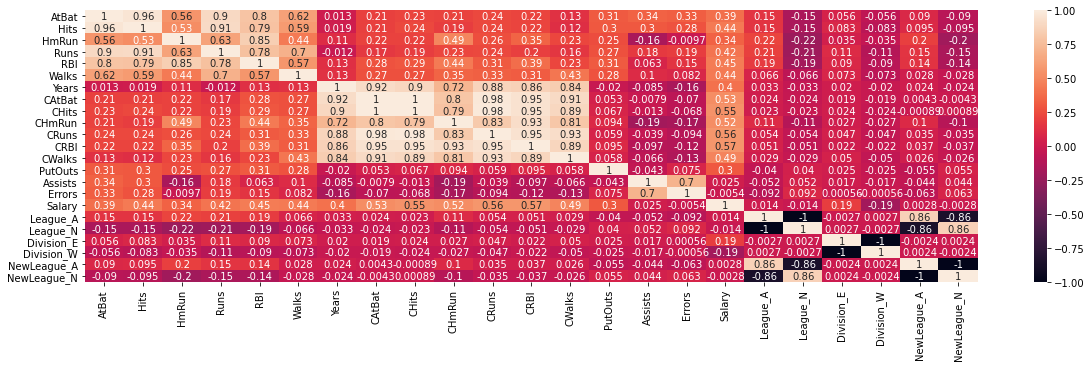

In [174]:
plt.figure(figsize = (20, 5))
sns.heatmap(Hitters.corr(), annot = True)

There are cases of multicolinearity, we will drop a few columns

In [175]:
Hitters.drop(columns = ["AtBat","Runs","CAtBat","CRuns","CRBI","League_A","Division_E","NewLeague_A","NewLeague_N"], inplace=True)
Hitters.shape

(263, 14)

<AxesSubplot:>

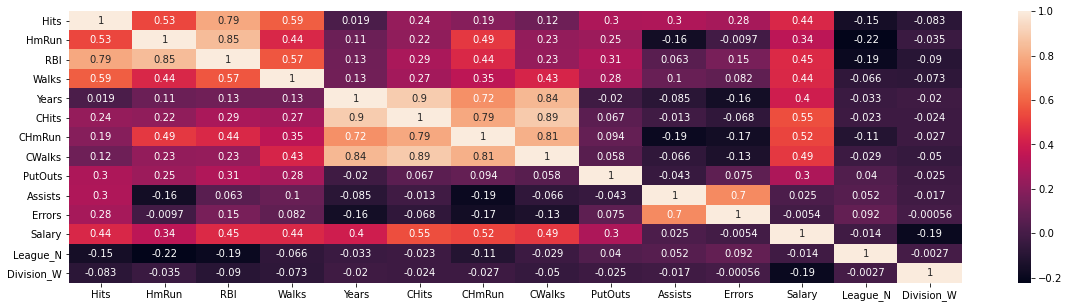

In [176]:
plt.figure(figsize = (20, 5))
sns.heatmap(Hitters.corr(), annot = True)

## A simple Sequential Forward Selection example
Initializing a simple regressor from scikit-learn:

In [177]:
y = Hitters['Salary']
X = sm.add_constant(Hitters.loc[:, Hitters.columns.drop('Salary')])

The SequentialFeatureSelector supports scikit-learn's estimators for regression.The trick is choosing a good [scoring](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values) metric.

We start by selection the "best" 14 features from the `Hitters` dataset via Sequential Forward Selection (SFS). Here, we set `forward=True` and `floating=False`. By choosing `cv=5`, we perform 5-fold cross-validation, therefore, the performance (here: 'RMSE') is estimated across the hold-out-sets.

We can visualize the output from the feature selection in a pandas DataFrame format using the `get_metric_dict` method of the SequentialFeatureSelector object. The columns `std_dev` and `std_err` represent the standard deviation and standard errors of the cross-validation scores, respectively.

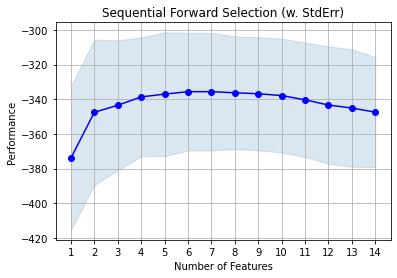

In [178]:
c = LinearRegression()

sfs = SequentialFeatureSelector(lr, 
          k_features=14, 
          forward=True, 
          floating=False, 
          scoring='neg_root_mean_squared_error',
          cv=5)

sfs = sfs.fit(X, y)
fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

We can access the indices of the best features directly via the `k_feature_idx_` attribute, and the prediction score for these features can be accesses via `k_score_`

In [179]:
print('Best RMSE: %.2f' % -sfs.k_score_)
print('Best subset (indices):', sfs.k_feature_idx_)
print('Best subset (corresponding names):', sfs.k_feature_names_)

Best RMSE: 347.46
Best subset (indices): (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13)
Best subset (corresponding names): ('const', 'Hits', 'HmRun', 'RBI', 'Walks', 'Years', 'CHits', 'CHmRun', 'CWalks', 'PutOuts', 'Assists', 'Errors', 'League_N', 'Division_W')


For our convenience, we can visualize the output from the feature selection in a pandas DataFrame format using the `get_metric_dict` method of the SequentialFeatureSelector object. The columns `std_dev` and `std_err` represent the standard deviation and standard errors of the cross-validation scores, respectively.

---

#### Feature Names

When working with large datasets, the feature indices might be hard to interpret. In this case, use pandas DataFrames with distinct column names as input:Below, we see the DataFrame of the Sequential Forward Selector from above:

In [180]:
pd.DataFrame.from_dict(sfs.get_metric_dict()).T.sort_values("avg_score", ascending=False)

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
6,"(4, 5, 6, 7, 9, 13)","[-272.36200817105504, -394.0099134713445, -274...",-335.631,"(Walks, Years, CHits, CHmRun, PutOuts, Divisio...",87.1933,67.8393,33.9197
7,"(0, 4, 5, 6, 7, 9, 13)","[-272.36200817105424, -394.0099134713443, -274...",-335.631,"(const, Walks, Years, CHits, CHmRun, PutOuts, ...",87.1933,67.8393,33.9197
8,"(0, 1, 4, 5, 6, 7, 9, 13)","[-262.7589207979038, -384.7119325247313, -280....",-336.274,"(const, Hits, Walks, Years, CHits, CHmRun, Put...",83.6185,65.058,32.529
9,"(0, 1, 4, 5, 6, 7, 9, 12, 13)","[-261.8768386534192, -385.94478961474437, -279...",-336.833,"(const, Hits, Walks, Years, CHits, CHmRun, Put...",83.7971,65.197,32.5985
5,"(4, 6, 7, 9, 13)","[-256.40619343019, -405.65283819058084, -285.2...",-337.052,"(Walks, CHits, CHmRun, PutOuts, Division_W)",91.7403,71.377,35.6885
10,"(0, 1, 4, 5, 6, 7, 9, 11, 12, 13)","[-263.7998696737819, -384.3343638372092, -280....",-337.87,"(const, Hits, Walks, Years, CHits, CHmRun, Put...",84.4221,65.6833,32.8416
4,"(4, 6, 9, 13)","[-261.06622847922563, -411.898326124341, -291....",-338.66,"(Walks, CHits, PutOuts, Division_W)",88.1263,68.5652,34.2826
11,"(0, 1, 4, 5, 6, 7, 9, 10, 11, 12, 13)","[-263.38367801727776, -385.7106844583628, -279...",-340.339,"(const, Hits, Walks, Years, CHits, CHmRun, Put...",84.671,65.8769,32.9385
12,"(0, 1, 2, 4, 5, 6, 7, 9, 10, 11, 12, 13)","[-263.95142760245983, -387.26040884495103, -28...",-343.34,"(const, Hits, HmRun, Walks, Years, CHits, CHmR...",87.0256,67.7088,33.8544
3,"(4, 6, 13)","[-250.22367704268598, -433.55643471734356, -32...",-343.458,"(Walks, CHits, Division_W)",96.2924,74.9187,37.4594


You could take the results above and rerun the model with your chosen variables, but it is not necessary as you get the same result. 

In [181]:
# Generate the new subsets based on the selected features
# Note that the transform call is equivalent to
X_tran=X.iloc[:, [4, 5, 6, 7, 9, 13]]

#X_trans=sfs.transform(X)

scores_regr = cross_val_score(regr, X_tran, y, cv=5,scoring='neg_root_mean_squared_error')
-scores_regr.mean()

335.631112588591

## Toggling between SFS, SBS, SFFS, and SBFS
Using the `forward` and `floating` parameters, we can toggle between SFS, SBS, SFFS, and SBFS. Note that we are performing (stratified) 5-fold cross-validation for more robust error estimates. Via `n_jobs=-1`, we choose to run the cross-validation on all our available CPU cores.

In [182]:
# Sequential Forward Selection
sfs = SequentialFeatureSelector(lr, 
          k_features=6, 
          forward=True, 
          floating=False, 
          scoring='neg_root_mean_squared_error',
          cv=5,
          n_jobs=-1)
sfs = sfs.fit(X, y)

print('\nSequential Forward Selection (k=6):')
print(sfs.k_feature_idx_)
print('CV Score:')
print(sfs.k_score_)

###################################################

# Sequential Backward Selection
sbs = SequentialFeatureSelector(lr, 
          k_features=6, 
          forward=False, 
          floating=False, 
          scoring='neg_root_mean_squared_error',
          cv=5,
          n_jobs=-1)
sbs = sbs.fit(X, y)

print('\nSequential Backward Selection (k=6):')
print(sbs.k_feature_idx_)
print('CV Score:')
print(sbs.k_score_)

###################################################

# Sequential Forward Floating Selection
sffs = SequentialFeatureSelector(lr, 
           k_features=6, 
           forward=True, 
           floating=True, 
           scoring='neg_root_mean_squared_error',
           cv=5,
           n_jobs=-1)
sffs = sffs.fit(X, y)

print('\nSequential Forward Floating Selection (k=6):')
print(sffs.k_feature_idx_)
print('CV Score:')
print(sffs.k_score_)

###################################################

# Sequential Backward Floating Selection
sbfs = SequentialFeatureSelector(lr, 
           k_features=6, 
           forward=False, 
           floating=True, 
           scoring='neg_root_mean_squared_error',
           cv=5,
           n_jobs=-1)
sbfs = sbfs.fit(X, y)

print('\nSequential Backward Floating Selection (k=6):')
print(sbfs.k_feature_idx_)
print('CV Score:')
print(sbfs.k_score_)


Sequential Forward Selection (k=66):
(4, 5, 6, 7, 9, 13)
CV Score:
-335.6311125885915

Sequential Backward Selection (k=6):
(4, 5, 6, 7, 9, 13)
CV Score:
-335.6311125885915

Sequential Forward Floating Selection (k=6):
(4, 5, 6, 7, 9, 13)
CV Score:
-335.6311125885915

Sequential Backward Floating Selection (k=6):
(4, 5, 6, 7, 9, 13)
CV Score:
-335.6311125885915


In this simple scenario, selecting the best 6 features out of the 14 available features in the Hitters set, we end up with similar results regardless of which sequential selection algorithms we used.

---

# Ridge Regression and the Lasso
We will use the `sklearn.linear_model` package (for which we use skl as shorthand below) to fit ridge and lasso regularized linear models on the `Hitters` data. We start with the model matrix `X` (without an intercept) that we computed in the previous section on selection.

## Ridge Regression
The `Ridge()` function has an alpha argument ($\lambda$, but with a different name!) that is used to tune the model. We'll generate an array of alpha values ranging from very big to very small, essentially covering the full range of scenarios from the null model containing only the intercept, to the least squares fit:

In [198]:
alphas = 10**np.linspace(10,-2,100)*0.5
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_root_mean_squared_error', normalize = True)
ridgecv.fit(X, y)
ridgecv.alpha_

D:\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


0.18824679033962358

In [199]:
dir(ridgecv)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_feature_names',
 '_check_n_features',
 '_decision_function',
 '_estimator_type',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_preprocess_data',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_set_intercept',
 '_validate_data',
 'alpha_',
 'alpha_per_target',
 'alphas',
 'best_score_',
 'coef_',
 'cv',
 'feature_names_in_',
 'fit',
 'fit_intercept',
 'gcv_mode',
 'get_params',
 'intercept_',
 'n_features_in_',
 'normalize',
 'predict',
 'score',
 'scoring',
 'set_params',
 'store_cv_values']

In [200]:
ridgecv.best_score_

-342.4117821235224

### Plot Ridge coefficients as a function of the regularization

Shows the effect of collinearity in the coefficients of an estimator.

Ridge Regression is the estimator used in this example. Each color represents a different feature of the coefficient vector, and this is displayed as a function of the regularization parameter.

This example also shows the usefulness of applying Ridge regression to highly ill-conditioned matrices. For such matrices, a slight change in the target variable can cause huge variances in the calculated weights. In such cases, it is useful to set a certain regularization (alpha) to reduce this variation (noise).

When alpha is very large, the regularization effect dominates the squared loss function and the coefficients tend to zero. At the end of the path, as alpha tends toward zero and the solution tends towards the ordinary least squares, coefficients exhibit big oscillations. In practise it is necessary to tune alpha in such a way that a balance is maintained between both.

[Source](https://scikit-learn.org/stable/auto_examples/linear_model/plot_ridge_path.html#plot-ridge-coefficients-as-a-function-of-the-regularization)

---

#### Compute Paths

In [201]:
coefs = []
for a in alphas:
    ridge = Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)

#### Display Results

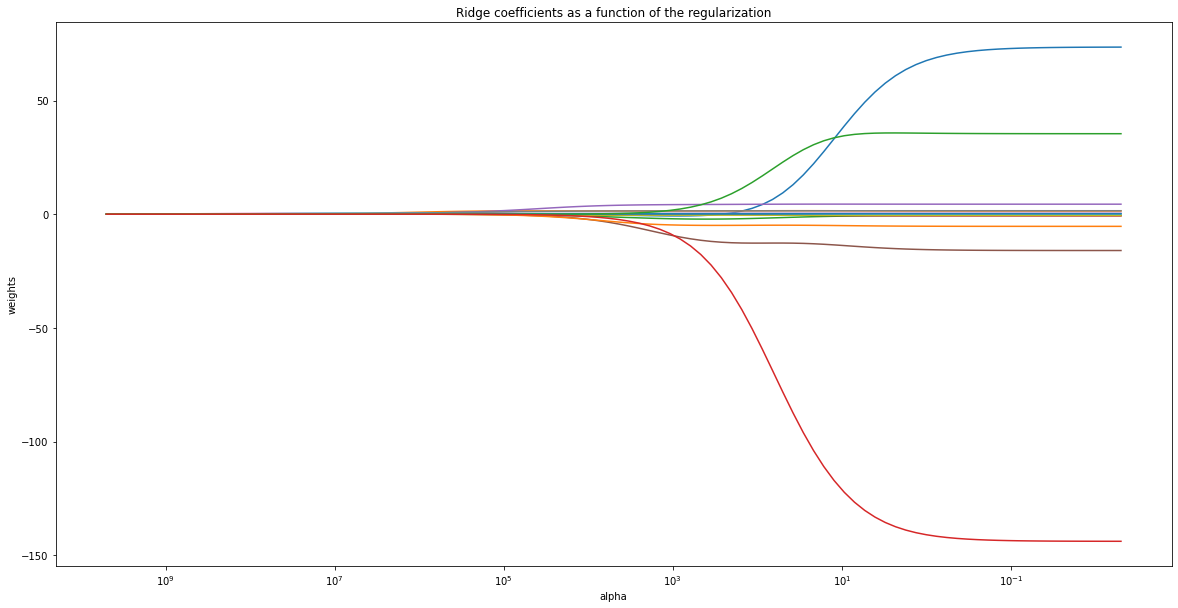

In [212]:
# Set the figure size
plt.figure(figsize=(20, 10))  # Adjust width and height as needed

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Ridge coefficients as a function of the regularization")
plt.axis("tight")
plt.show()

In [214]:
ridge = Ridge(alpha=ridgecv.best_score_, fit_intercept=False)
ridge.fit(X, y)
pd.Series(ridge.coef_, index = X.columns)

const         -1.643366
Hits           1.321375
HmRun         -3.641437
RBI            0.600736
Walks          4.168310
Years        -21.275125
CHits          0.450299
CHmRun         1.427200
CWalks        -0.364205
PutOuts        0.266558
Assists        0.133277
Errors        -5.366962
League_N      -8.957238
Division_W    32.007086
dtype: float64

None of the coefficients are exactly zero - ridge regression does not perform variable selection!

---

## The Lasso
We saw that ridge regression with a wise choice of alpha didn't outperform our subset model on the `Hitters` data set. We now ask whether the lasso can yield either a more accurate or a more interpretable model than ridge regression. In order to fit a lasso model, we'll use the `LassoCV()` function; however, this time we'll need to include the argument `max_iter = 10000`. Other than that change, we proceed just as we did in fitting a ridge model:

In [228]:
lasso_cv = LassoCV(alphas = [0.0001, 0.001,0.01, 0.1, 1, 10], 
                   cv = 5, 
                   max_iter = 100000, 
                   normalize = True, 
                   random_state=0).fit(X, y)
lassocv.alpha_
# lasso.set_params(alpha=lassocv.alpha_)
# lasso.fit(X_train, y_train)
# mean_squared_error(y_test, lasso.predict(X_test))

D:\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


0.7073806393672835

In [226]:
lassocv.get_params(deep=True)

{'alphas': None,
 'copy_X': True,
 'cv': 10,
 'eps': 0.001,
 'fit_intercept': True,
 'max_iter': 100000,
 'n_alphas': 100,
 'n_jobs': None,
 'normalize': True,
 'positive': False,
 'precompute': 'auto',
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'verbose': False}

In [231]:
cross_val_score(lasso_cv, X, y,scoring='neg_root_mean_squared_error',cv=5).mean()

D:\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
D:\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline imp

-349.45246685263845

In [234]:
pd.Series(lasso_cv.coef_, index = X.columns)

const           0.000000
Hits            1.831085
HmRun           0.000000
RBI             0.000000
Walks           2.389770
Years          -0.000000
CHits           0.206831
CHmRun          0.902615
CWalks          0.000000
PutOuts         0.223462
Assists        -0.000000
Errors         -0.000000
League_N        3.628513
Division_W   -106.178700
dtype: float64

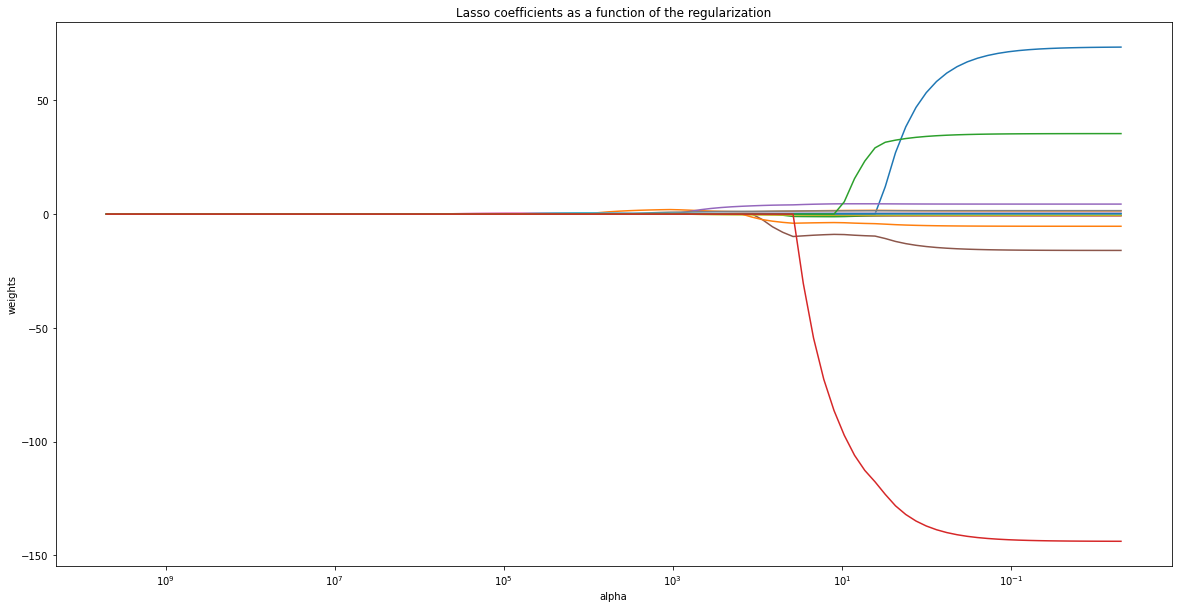

In [237]:
coefs = []
for a in alphas:
    ridge = Lasso(alpha=a, fit_intercept=False)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)

# Set the figure size
plt.figure(figsize=(20, 10))  # Adjust width and height as needed

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Lasso coefficients as a function of the regularization")
plt.axis("tight")
plt.show()